Open Health Inspection Analysis
=================

The following notebook explores data produced by the Open Health Inspection app (https://ohi.code4hr.org/) developed by Code for Hampton Roads (http://code4hr.org/). The source data is located at https://ohi-api.code4hr.org/bulk/


# What does the data look like?? What are the number of records (food service establishments with inspection scores) and fields in the dataset?

In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
%matplotlib inline

df = pd.read_json("va_health_inspections_1000.json", lines=True)
df = df[~np.isnan(df['score'])]  #remove any records that have no 'score'
print(df.info())
#df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 1 to 999
Data columns (total 24 columns):
_id                     991 non-null object
address                 991 non-null object
baseUrl                 370 non-null object
category                985 non-null object
city                    991 non-null object
geo                     777 non-null object
guid                    991 non-null object
inserted                370 non-null object
inspections             991 non-null object
last_inspection_date    991 non-null object
locality                991 non-null object
locality_id             808 non-null object
locality_url            808 non-null object
name                    991 non-null object
phone                   808 non-null object
score                   991 non-null float64
search_name             991 non-null object
slug                    991 non-null object
smoking                 425 non-null float64
status                  808 non-null object
type         

# How are the food service establishments categorized, both broadly ('Categories') and granularly ('Types')?

In [270]:
categories = df['category'].unique()
types = df['type'].unique()
print('Categories: {}'.format(categories.size)); pprint(categories)
print('\nTypes: {}'.format(types.size)); pprint(types)

Categories: 9
array(['Education', 'Medical', 'Mobile Food', 'Hospitality', 'Restaurant',
       'Government', 'Grocery', nan, 'Other'], dtype=object)

Types: 29
array(['Public Elementary School Food Service',
       'Adult Care Home Food Service', 'Mobile Food Unit',
       'Hotel Continental Breakfast', 'Full Service Restaurant',
       'Nursing Home Food Service', 'Jail Food Service',
       'Fast Food Restaurant', 'Summer Camp Food Service',
       'Private Middle or High School Food Service',
       'Bed & Breakfast Food Service', 'Full Service Restaurant/Caterer',
       'Carry Out Food Service Only', 'Child Care Food Service',
       'Seasonal Fast Food Restaurant',
       'Public Middle or High School Food Service',
       'Hospital Food Service', 'Fast Food Restaurant/Caterer', 'Caterer',
       'Unknown', 'Adult Day Care Food Service', 'Other Food Service',
       'Private College Food Service', 'Group Home Food Service',
       'Seasonal Full Service Restaurant',
       'Conv

# What is the distribution of inspection scores? ... encouraging

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



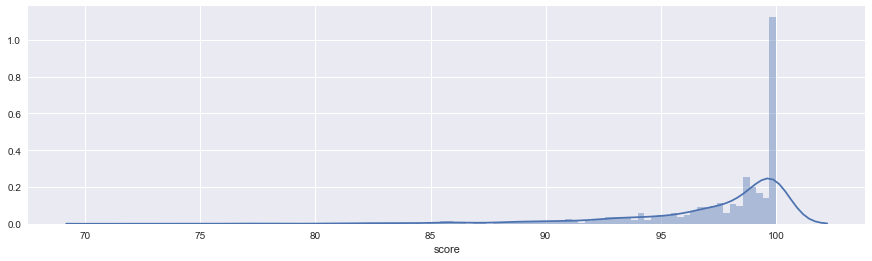

In [271]:
scores = df['score']
sns.set(rc={"figure.figsize": (15, 4)})
sns.distplot(scores, bins=100)

# What is the scoring spread for each food service category?

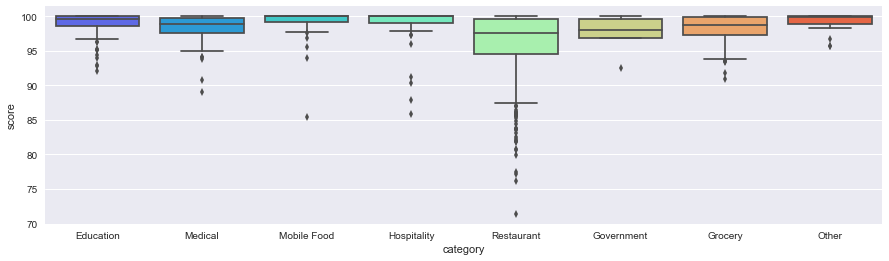

In [272]:
sns.boxplot(x="category", y="score", data=df, palette='rainbow')

# What are the number of establishments in each category and the average, standard deviation, minimum, maximum, and quartile distribution for inspection scores per category?

In [273]:
scoreByCategory = df.drop('smoking', axis=1)
scoreByCategory = scoreByCategory.groupby('category').describe().unstack()
scoreByCategory = scoreByCategory['score'].sort_values('count', ascending=False).reset_index()
scoreByCategory


,category,count,mean,std,min,25%,50%,75%,max
0,Restaurant,595.0,96.251092,4.451918,71.40,94.575,97.60,99.55,100.0
1,Education,133.0,98.942481,1.586048,92.05,98.600,99.55,100.00,100.0
2,Mobile Food,65.0,99.177692,2.076619,85.40,99.100,100.00,100.00,100.0
3,Hospitality,61.0,98.772131,2.833542,85.90,98.950,100.00,100.00,100.0
4,Medical,55.0,98.096364,2.323090,89.00,97.600,98.80,99.70,100.0
5,Grocery,50.0,98.038000,2.308913,90.95,97.325,98.75,99.85,100.0
6,Other,19.0,98.986842,1.455053,95.65,98.800,99.85,100.00,100.0
7,Government,7.0,97.607143,2.604872,92.55,96.800,98.00,99.55,100.0


# What are the number of food service establishments in each *category*?

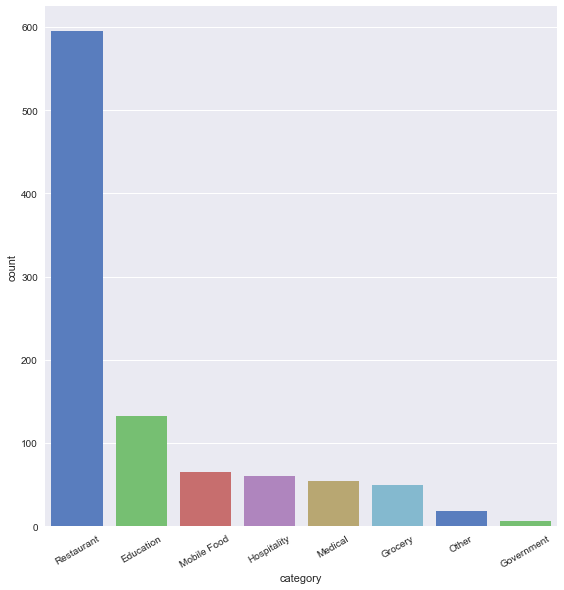

In [274]:
# Needed more features than countplot() supports
scoresByCategory = df.drop('smoking', axis=1)
scoresByCategory = scoresByCategory.groupby('category').describe().unstack()
scoresByCategory = scoresByCategory['score'].sort_values('count', ascending=False).reset_index()
#scoreByCategory

s = sns.factorplot(x='category',y='count',data=scoresByCategory,kind='bar',  size = 8, palette='muted')
s.set_xticklabels(rotation=30)

# What are the number of food service establishments in each *type*?

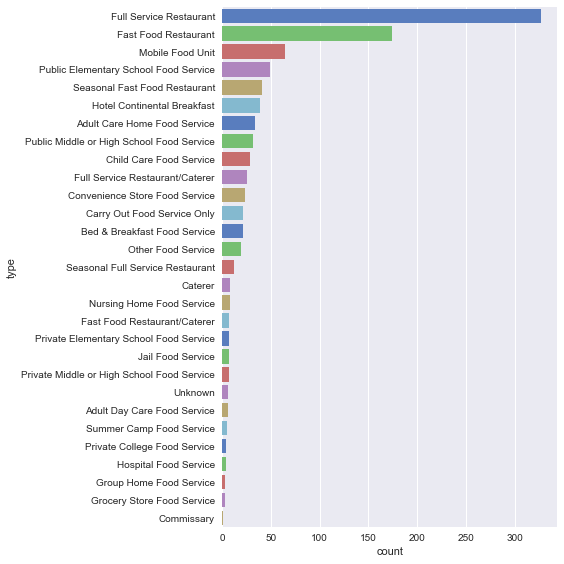

In [275]:
# Needed more features than countplot() supports
scoresByType = df.drop('smoking', axis=1)
scoresByType = scoresByType.groupby('type').describe().unstack()
scoresByType = scoresByType['score'].sort_values('count', ascending=False).reset_index()
#scoreByCategory

sns.factorplot(x='count',y='type',data=scoresByType,kind='bar',  size = 8, palette='muted')


# Interactive plotly graphs

In [276]:
# Does not work within GitHub env

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# For Notebooks
init_notebook_mode(connected=True)

scoresByCategory.iplot(kind='bar',y='count',x='category')